In [4]:
import numpy as np
import pandas as pd

In [5]:
# location of file
FILE_PATH = 'archive/AMZN_2006-01-01_to_2018-01-01.csv'

# Reading the file data
data = pd.read_csv(FILE_PATH)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


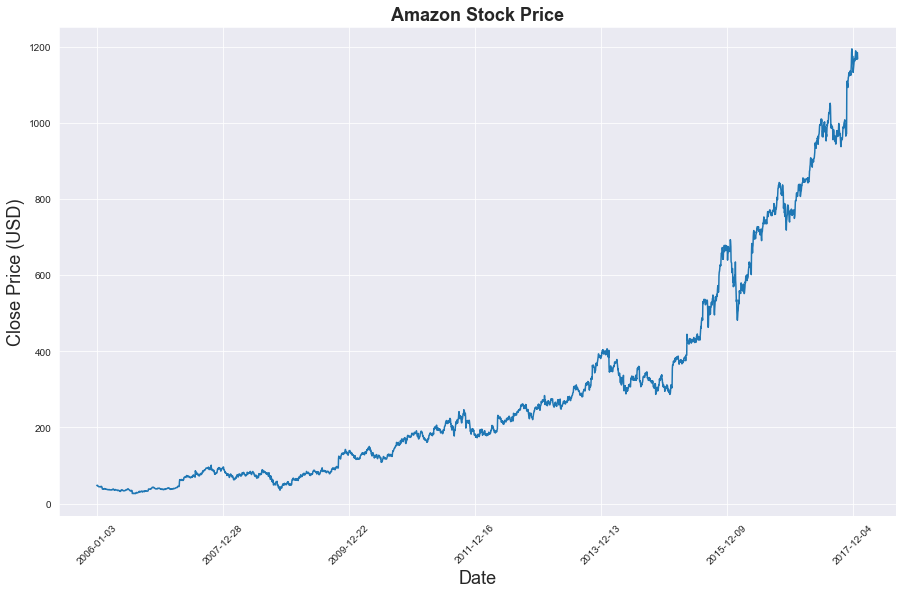

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [7]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 47.2 KB


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


C:\Users\Ankush\AppData\Local\Temp\ipykernel_4952\2307885146.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [9]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]


In [10]:
lookback = 20 # choose sequence length

x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


Converting datasets to tensors for PyTorch

In [11]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [15]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

# make 100
num_epochs = 10

Model specification

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

Instantiating model

In [15]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

## Training the model

In [16]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.7680176496505737
Epoch  1 MSE:  0.5429216623306274
Epoch  2 MSE:  0.3489067256450653
Epoch  3 MSE:  0.13329485058784485
Epoch  4 MSE:  0.05429845675826073
Epoch  5 MSE:  0.14352816343307495
Epoch  6 MSE:  0.0723327249288559
Epoch  7 MSE:  0.033204030245542526
Epoch  8 MSE:  0.04639768227934837
Epoch  9 MSE:  0.06440940499305725
Training time: 6.4310595989227295


In [17]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

## Plotting predictions

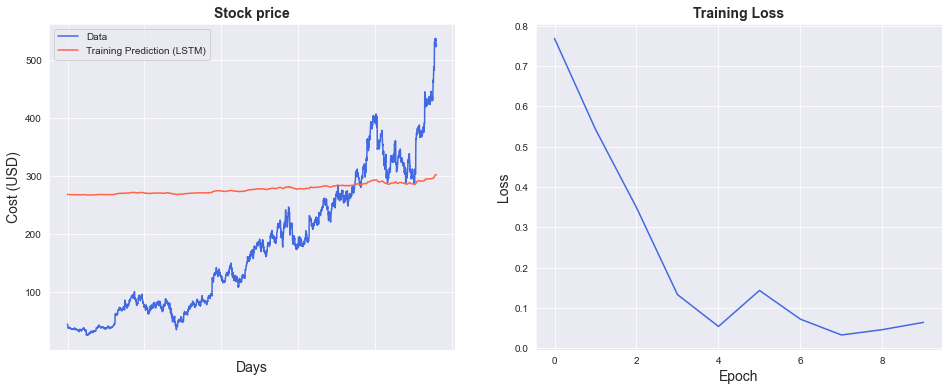

In [18]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [19]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 148.44 RMSE
Test Score: 496.51 RMSE


## Model with GRU

In [102]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

# make 100
num_epochs = 100

In [103]:
lookback = 10 # choose sequence length

x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (2407, 9, 1)
y_train.shape =  (2407, 1)
x_test.shape =  (602, 9, 1)
y_test.shape =  (602, 1)


In [104]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


Initializing model

In [105]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [127]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

## Training GRU model

In [107]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    
    if t%10 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.8478827476501465
Epoch  10 MSE:  0.05710108205676079
Epoch  20 MSE:  0.018605707213282585
Epoch  30 MSE:  0.009076541289687157
Epoch  40 MSE:  0.001637091627344489
Epoch  50 MSE:  0.0009139953763224185
Epoch  60 MSE:  0.0007067858823575079
Epoch  70 MSE:  0.00023466635320801288
Epoch  80 MSE:  0.0002397849748376757
Epoch  90 MSE:  0.00018714838370215148
Training time: 21.145891666412354


Model MSE:  7.737342159916808


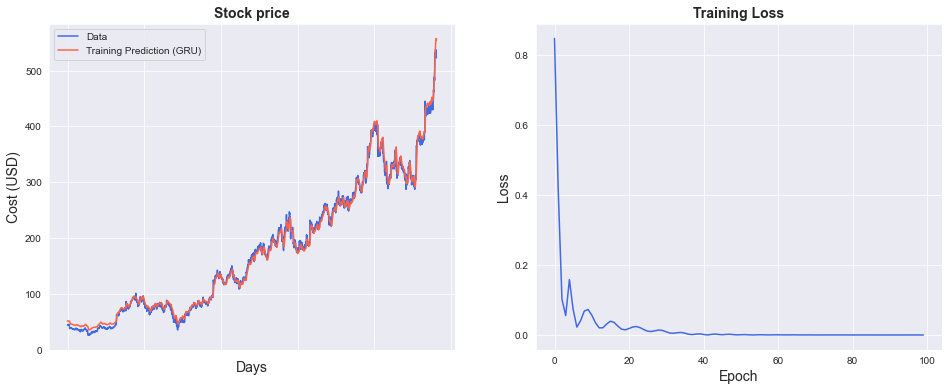

In [108]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

print("Model MSE: ", MSE(predict, original))

In [109]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 7.74 RMSE
Test Score: 33.55 RMSE


## Testing plot

Model MSE:  0.05736671823252121


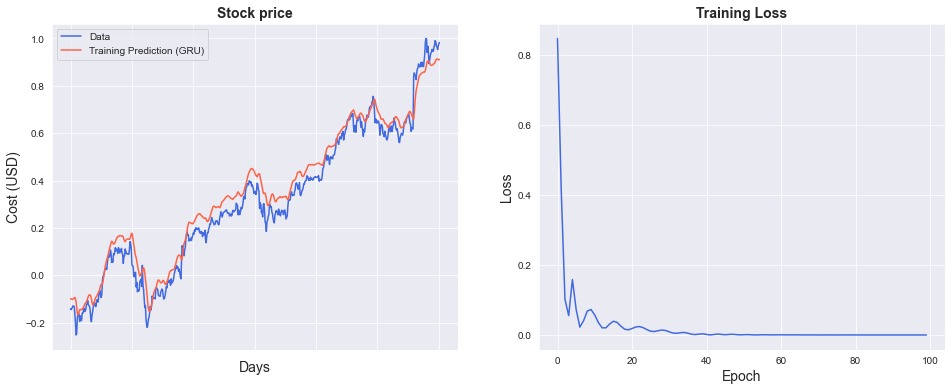

In [110]:
# predict = pd.DataFrame(scaler2.inverse_transform(y_test_pred.detach().numpy()))
# original = pd.DataFrame(scaler2.inverse_transform(y_test_gru.detach().numpy()))

y_test_pred = model(x_test)

predict = pd.DataFrame((y_test_pred.detach().numpy()))
original = pd.DataFrame((y_test_gru.detach().numpy()))

import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

print("Model MSE: ", MSE(predict, original))

In [136]:
x_train.shape

torch.Size([2399, 19, 1])

In [138]:
model(torch.rand(1, 19, 1))

tensor([[0.6014]], grad_fn=<AddmmBackward0>)

In [176]:
future_steps = 200
input_tensor = x_train[-1].clone()
predicted_future = []

# input_tensor.reshape(1, 19, 1)

for i in range(future_steps):
    prediction = model(input_tensor.reshape(1, 19, 1))
    predicted_future.append(float(prediction))
    
    input_tensor = torch.cat((input_tensor[:-1], torch.tensor([[prediction]])))
    
# predicted_future

In [177]:
len(y_test_gru)

600

Model MSE:  66.14609472211684


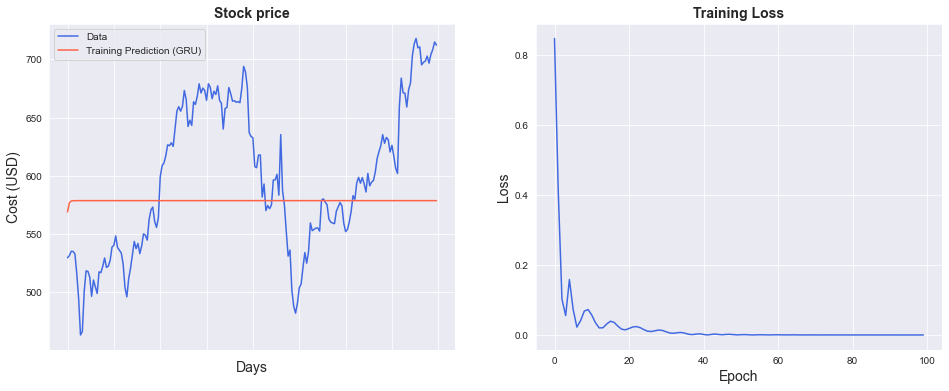

In [181]:
# predict = pd.DataFrame(scaler2.inverse_transform(y_test_pred.detach().numpy()))
# original = pd.DataFrame(scaler2.inverse_transform(y_test_gru.detach().numpy()))

y_test_pred = predicted_future

predict = pd.DataFrame(scaler.inverse_transform(np.array(y_test_pred).reshape(-1, 1)))
original = pd.DataFrame(scaler.inverse_transform(y_test_gru[:200].detach().numpy()))

import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

print("Model MSE: ", MSE(predict, original))

## Baseline model

In [101]:
def MSE(predicted, original):
    return (np.sum((predicted - original).to_numpy()**2)/len(predicted))**0.5

#### Average of last three days

In [118]:
lookback = 20 # choose sequence length

x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


In [119]:
y_train_pred = np.apply_along_axis(np.mean, 1, x_train)
y_test_pred = np.apply_along_axis(np.mean, 1, x_test)

Model MSE: 0.01913192926594469


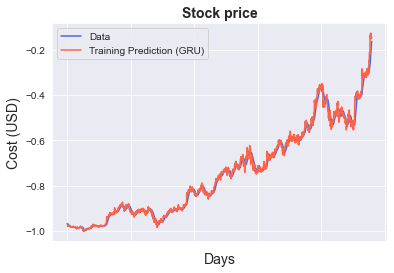

In [120]:
# training plots
predict = pd.DataFrame(y_train)
original = pd.DataFrame(y_train_pred)

import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

print("Model MSE:", MSE(predict, original))

Model MSE: 0.05326274200882865


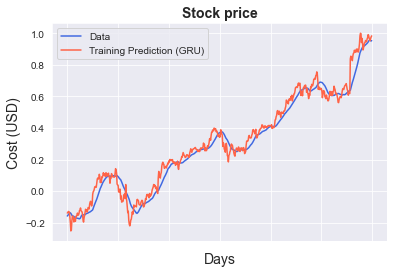

In [121]:
# test set

predict = pd.DataFrame(y_test)
original = pd.DataFrame(y_test_pred)

import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

print("Model MSE:", MSE(predict, original))

#### Same as last day

In [75]:
lookback = 2 # choose sequence length

x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (2414, 1, 1)
y_train.shape =  (2414, 1)
x_test.shape =  (603, 1, 1)
y_test.shape =  (603, 1)


In [76]:
# predictions
y_train_pred = np.apply_along_axis(np.sum, 1, x_train)
y_test_pred = np.apply_along_axis(np.sum, 1, x_test)

Model MSE: 0.1383785438086046


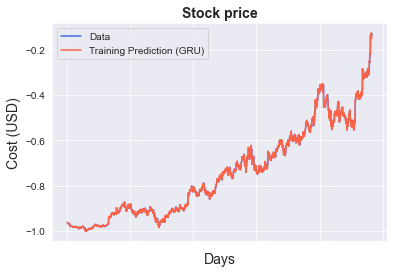

In [77]:
# training plots
predict = pd.DataFrame(y_train)
original = pd.DataFrame(y_train_pred)

import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

print("Model MSE:", MSE(predict, original))

Model MSE: 0.024066552467403086


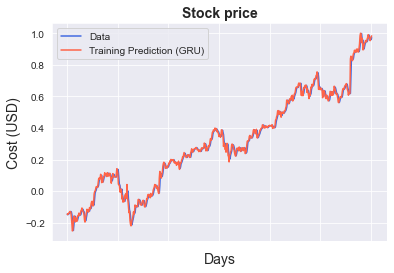

In [116]:
# test set

predict = pd.DataFrame(y_test)
original = pd.DataFrame(y_test_pred)

import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

print("Model MSE:", MSE(predict, original))

## KNN Baseline ❌

In [200]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import preprocessing
from sklearn import utils

In [185]:
lookback = 20 # choose sequence length

x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


In [190]:
x_train.reshape(2399,19)

array([[-0.96322323, -0.96378744, -0.96310354, ..., -0.96818151,
        -0.96725824, -0.96770278],
       [-0.96378744, -0.96310354, -0.9627274 , ..., -0.96725824,
        -0.96770278, -0.96794214],
       [-0.96310354, -0.9627274 , -0.9640781 , ..., -0.96770278,
        -0.96794214, -0.96937833],
       ...,
       [-0.24856381, -0.25605252, -0.23162016, ..., -0.12641909,
        -0.13932773, -0.15102243],
       [-0.25605252, -0.23162016, -0.21874573, ..., -0.13932773,
        -0.15102243, -0.14866297],
       [-0.23162016, -0.21874573, -0.21004309, ..., -0.15102243,
        -0.14866297, -0.14274723]])

In [209]:
knn = KNeighborsRegressor(n_neighbors=10)

# lab = preprocessing.LabelEncoder()
# y_train = lab.fit_transform(y_train)


knn.fit(
   x_train.reshape(2399, 19),
   y_train.reshape(2399),
)
# y_pred = knn.predict(X_test)
# print(accuracy_score(y_test, y_pred))

KNeighborsRegressor(n_neighbors=10)

In [210]:
y_pred = knn.predict(x_test.reshape(-1, 19))
y_pred

array([2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
       2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
       2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
       2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
       2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
       2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
       2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
       2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
       2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
       2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
       2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
       2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
       2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
       2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9, 2277.9,
      

In [205]:
print(accuracy_score(y_test, y_pred))

ValueError: continuous is not supported